### some functions for model construction

In [96]:
%reset
import gzip
import os
import numpy
import tensorflow as tf

WORK_DIRECTORY = 'data'
IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
VALIDATION_SIZE = 5000  # Size of the validation set.
NUM_EPOCHS = 10
FLAGS = None
BATCH_SIZE = 64
SEED = 66478  # Set to None for random seed.
NUM_LABELS = 10
EVAL_BATCH_SIZE = 64

# We will replicate the model structure for the training subgraph, as well
# as the evaluation subgraphs, while sharing the trainable parameters.
def model(data, train=False):
    """The Model definition."""
    # 2D convolution, with 'SAME' padding (i.e. the output feature map has
    # the same size as the input). Note that {strides} is a 4D array whose
    # shape matches the data layout: [image index, y, x, depth].
    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    # Bias and rectified linear non-linearity.
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
    # Max pooling. The kernel size spec {ksize} also follows the layout of
    # the data. Here we have a pooling window of 2, and a stride of 2.
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    # Reshape the feature map cuboid into a 2D matrix to feed it to the
    # fully connected layers.
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(
        pool,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
    # Fully connected layer. Note that the '+' operation automatically
    # broadcasts the biases.
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    if train:
        hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
    return tf.matmul(hidden, fc2_weights) + fc2_biases

def maybe_download(filename):
    """Download the data from Yann's website, unless it's already here."""
    if not tf.gfile.Exists(WORK_DIRECTORY):
        tf.gfile.MakeDirs(WORK_DIRECTORY)
    filepath = os.path.join(WORK_DIRECTORY, filename)
    if not tf.gfile.Exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
    with tf.gfile.GFile(filepath) as f:
        size = f.size()
    print('Successfully downloaded', filename, size, 'bytes.')
    return filepath

def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
        return data


def extract_labels(filename, num_images):
    """Extract the labels into a vector of int64 label IDs."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.int64)
    return labels

def data_type():
    """Return the type of the activations, weights, and placeholder variables."""
    return tf.float32



Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### original model structure

In [97]:

# Get the data.
train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

# Extract it into numpy arrays.
train_data = extract_data(train_data_filename, 60000)
train_labels = extract_labels(train_labels_filename, 60000)
test_data = extract_data(test_data_filename, 10000)
test_labels = extract_labels(test_labels_filename, 10000)

# Generate a validation set.
validation_data = train_data[:VALIDATION_SIZE, ...]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:, ...]
train_labels = train_labels[VALIDATION_SIZE:]
num_epochs = NUM_EPOCHS

train_size = train_labels.shape[0]

# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step using the {feed_dict} argument to the Run() call below.
# with tf.variable_scope("conv"):
train_data_node = tf.placeholder(
  data_type(),
  shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
train_labels_node = tf.placeholder(tf.int64, shape=(BATCH_SIZE,))
eval_data = tf.placeholder(
  data_type(),
  shape=(EVAL_BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))

# The variables below hold all the trainable weights. They are passed an
# initial value which will be assigned when we call:
# {tf.global_variables_initializer().run()}
with tf.variable_scope("conv"):
    conv1_weights = tf.Variable(
      tf.truncated_normal([5, 5, NUM_CHANNELS, 32],  # 5x5 filter, depth 32.
                          stddev=0.1,
                          seed=SEED, dtype=data_type()))
    conv1_biases = tf.Variable(tf.zeros([32], dtype=data_type()))
    conv2_weights = tf.Variable(tf.truncated_normal(
      [5, 5, 32, 64], stddev=0.1,
      seed=SEED, dtype=data_type()))
    conv2_biases = tf.Variable(tf.constant(0.1, shape=[64], dtype=data_type()))
with tf.variable_scope("fc"):
    fc1_weights = tf.Variable(  # fully connected, depth 512.
      tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 64, 512],
                          stddev=0.1,
                          seed=SEED,
                          dtype=data_type()))
    fc1_biases = tf.Variable(tf.constant(0.1, shape=[512], dtype=data_type()))
    fc2_weights = tf.Variable(tf.truncated_normal([512, NUM_LABELS],
                                                stddev=0.1,
                                                seed=SEED,
                                                dtype=data_type()))
    fc2_biases = tf.Variable(tf.constant(
      0.1, shape=[NUM_LABELS], dtype=data_type()))

# Training computation: logits + cross-entropy loss.
logits = model(train_data_node, True)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
  labels=train_labels_node, logits=logits))

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
              tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
# Add the regularization term to the loss.
loss += 5e-4 * regularizers

('Successfully downloaded', 'train-images-idx3-ubyte.gz', 9912422L, 'bytes.')
('Successfully downloaded', 'train-labels-idx1-ubyte.gz', 28881L, 'bytes.')
('Successfully downloaded', 't10k-images-idx3-ubyte.gz', 1648877L, 'bytes.')
('Successfully downloaded', 't10k-labels-idx1-ubyte.gz', 4542L, 'bytes.')
('Extracting', 'data/train-images-idx3-ubyte.gz')
('Extracting', 'data/train-labels-idx1-ubyte.gz')
('Extracting', 'data/t10k-images-idx3-ubyte.gz')
('Extracting', 'data/t10k-labels-idx1-ubyte.gz')


### restore trained model

In [98]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)
init = tf.global_variables_initializer()

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    # load model
    model_name = './LeNet.ckpt.meta'
    saver = tf.train.import_meta_graph(model_name)
    saver.restore(sess,'./LeNet.ckpt')

    w1 = conv1_weights.eval()
    w2 = conv2_weights.eval()
    w3 = fc1_weights.eval()
    w4 = fc2_weights.eval()
    
#     data = validation_data[0:256]
#     label = validation_labels[0:256]
    data = train_data[0:256]
    label = train_labels[0:256]
    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    # first conv layer activation
    act_conv1 = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases)).eval()
    pool = tf.nn.max_pool(act_conv1,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    act_conv2 = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases)).eval()
    # second conv layer activation
    pool = tf.nn.max_pool(act_conv2,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(
        pool,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
    # first fc layer activation
    act_fc1 = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases).eval()
    # second fc layer activation
    act_fc2 = tf.nn.softmax(tf.matmul(act_fc1, fc2_weights) + fc2_biases).eval()

    eval_prediction=model(data).eval()

In [124]:
numpy.argmax(eval_prediction,axis=1)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5])

### transpose convolution in cublas

In [216]:
w2.shape

(5, 5, 32, 64)

In [219]:
from theano.sandbox.cuda.basic_ops import gpu_contiguous
from theano.sandbox.cuda.blas import GpuCorrMM
import numpy as np


# upsample
up_w2 = np.zeros((w2.shape[0]*2,w2.shape[1]*2,w2.shape[2],w2.shape[3]))
import scipy.ndimage
for i in range(w2.shape[2]):
    for j in range(w2.shape[3]):
        up_w2[:,:,i,j] = scipy.ndimage.zoom(w2[:,:,i,j], 2, order=0)
up_w2 = up_w2.astype('float32')

ww1 = w1.transpose([2,3,0,1])
contiguous_W1 = gpu_contiguous(ww1)
ww2 = up_w2.transpose([3,2,0,1])
contiguous_W2 = gpu_contiguous(ww2)
strides = (1,1)
corr_mm_op = GpuCorrMM(subsample=strides,border_mode='full')
w1w2 = np.asarray(corr_mm_op(contiguous_W2,contiguous_W1).eval())

In [224]:
ww1.shape,ww2.shape,w1w2.shape

((1, 32, 5, 5), (64, 32, 10, 10), (64, 1, 14, 14))

### visualization of the first convolutional layer filter 

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns 

(-0.5, 39.5, 19.5, -0.5)

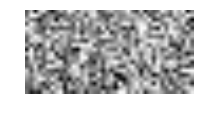

In [221]:
ww = numpy.zeros((4*5,8*5))
for i in range(4):
    for j in range(8):
        ww[5*i:5*(i+1),5*j:5*(j+1)] = w1[:,:,0,8*i+j]
plt.figure(figsize=(3,3))
plt.imshow(ww)
plt.grid('off')
plt.axis('off')

### visualization of the second convolutional layer filter 

(-0.5, 111.5, 111.5, -0.5)

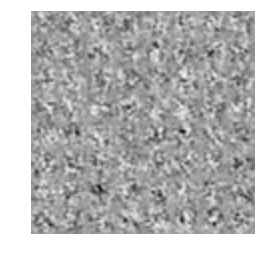

In [226]:
subsize = w1w2.shape[2]
ww = numpy.zeros((8*subsize,8*subsize))
for i in range(8):
    for j in range(8):
        ww[subsize*i:subsize*(i+1),subsize*j:subsize*(j+1)] = w1w2[8*i+j,0,:,:]
plt.figure(figsize=(4,4))
plt.imshow(ww)
plt.grid('off')
plt.axis('off')

### visualization of the first fully connected layer filter 

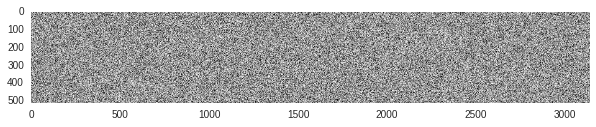

In [105]:
ww = numpy.zeros((8*9,8*9))
plt.figure(figsize=(10,10))
plt.imshow(w3.transpose())
plt.grid('off')
# plt.axis('off')

### visualization of the second fully connected layer filter 

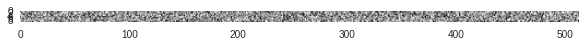

In [106]:
ww = numpy.zeros((8*9,8*9))
plt.figure(figsize=(10,10))
plt.imshow(w4.transpose())
plt.grid('off')
# plt.axis('off')

### visualization of the input image

(-0.5, 27.5, 27.5, -0.5)

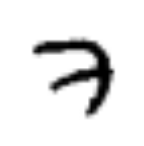

In [107]:
input_idx = 0
plt.figure(figsize=(2,2))
plt.imshow(np.squeeze(data[input_idx]))
plt.grid('off')
plt.axis('off')

### visualization of the first convolutional layer activation 

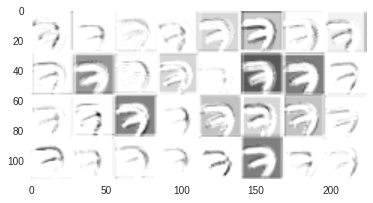

In [108]:
subsize = act_conv1.shape[2]
aa1 = numpy.zeros((4*subsize,8*subsize))
for i in range(4):
    for j in range(8):
        aa1[subsize*i:subsize*(i+1),subsize*j:subsize*(j+1)] = act_conv1[input_idx,:,:,8*i+j]
plt.figure(figsize=(6,6))
plt.imshow(aa1)
plt.grid('off')
# plt.axis('off')

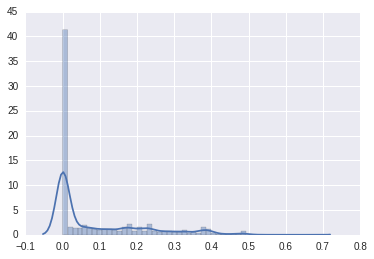

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure()
sns.distplot(aa1.flatten())
plt.show()

### visualization of the second convolutional layer activation 

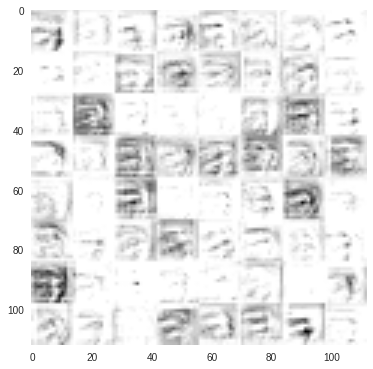

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns 

subsize = act_conv2.shape[2]

aa2 = numpy.zeros((8*subsize,8*subsize))
for i in range(8):
    for j in range(8):
        aa2[subsize*i:subsize*(i+1),subsize*j:subsize*(j+1)] = act_conv2[input_idx,:,:,8*i+j]

plt.figure(figsize=(6,6))
plt.imshow(aa2)
plt.grid('off')
# plt.axis('off')

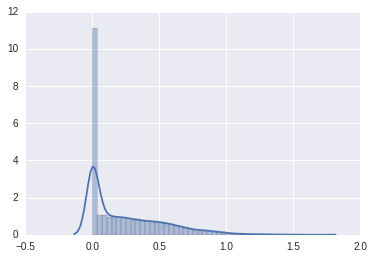

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure()
sns.distplot(aa2.flatten())
plt.show()

### visualization of the first fully connected layer activation 

(-0.5, 511.5, 29.5, -0.5)

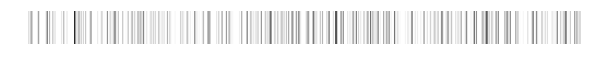

In [112]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
plt.imshow(numpy.repeat(numpy.expand_dims(act_fc1[input_idx], axis=1), 30, axis=1).transpose())
plt.grid('off')
plt.axis('off')


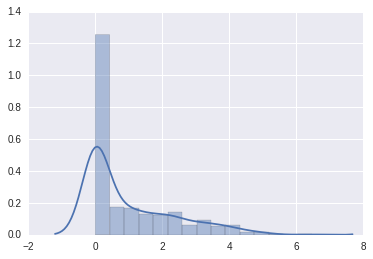

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure()
sns.distplot(act_fc1[input_idx].flatten())
plt.show()

### visualization of the second fully connected layer activation 

In [114]:
np.argmax(act_fc2,axis=1)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5])

In [115]:
label

array([7, 3, 4, 6, 1, 8, 1, 0, 9, 8, 0, 3, 1, 2, 7, 0, 2, 9, 6, 0, 1, 6, 7,
       1, 9, 7, 6, 5, 5, 8, 8, 3, 4, 4, 8, 7, 3, 6, 4, 6, 6, 3, 8, 8, 9, 9,
       4, 4, 0, 7, 8, 1, 0, 0, 1, 8, 5, 7, 1, 7, 5, 5, 9, 9, 4, 2, 5, 3, 7,
       4, 6, 6, 0, 1, 0, 1, 2, 4, 8, 5, 3, 5, 0, 0, 6, 4, 3, 8, 3, 7, 1, 4,
       3, 9, 2, 2, 0, 3, 6, 6, 7, 4, 3, 2, 2, 4, 9, 1, 0, 5, 2, 4, 8, 2, 1,
       0, 8, 4, 4, 8, 0, 6, 4, 1, 4, 9, 6, 3, 1, 2, 9, 0, 1, 0, 4, 2, 9, 9,
       4, 3, 8, 6, 9, 3, 0, 6, 7, 0, 3, 1, 4, 2, 3, 3, 0, 4, 2, 5, 5, 6, 3,
       7, 2, 8, 5, 9, 2, 0, 1, 1, 8, 2, 9, 3, 1, 4, 1, 5, 7, 6, 4, 7, 7, 8,
       3, 9, 3, 0, 5, 1, 3, 2, 0, 3, 0, 4, 0, 7, 4, 8, 8, 9, 0, 0, 1, 8, 7,
       3, 9, 9, 5, 5, 9, 6, 7, 8, 2, 4, 6, 9, 8, 1, 6, 7, 9, 1, 6, 2, 0, 9,
       6, 6, 2, 9, 1, 1, 2, 1, 3, 1, 5, 2, 7, 8, 0, 1, 0, 2, 8, 0, 2, 7, 3,
       7, 5, 5])

true label: 7


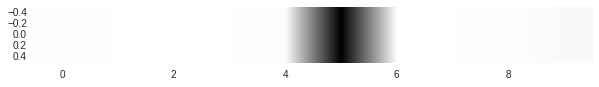

In [116]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
plt.imshow(numpy.repeat(numpy.expand_dims(act_fc2[input_idx], axis=1), 1, axis=1).transpose())
plt.grid('off')
# plt.axis('off')
print("true label: {}".format(label[input_idx]))

### Threshold on activation

In [155]:
up_w4w3.dtype

dtype('float64')

In [206]:
w4w3 = np.dot(w4.transpose(),w3.transpose()).reshape(10,7,7,64)

# upsample
up_w4w3 = np.zeros((w4w3.shape[0],w4w3.shape[1]*2,w4w3.shape[2]*2,w4w3.shape[3]))
import scipy.ndimage
for i in range(w4w3.shape[0]):
    for j in range(w4w3.shape[3]):
        up_w4w3[i,:,:,j] = scipy.ndimage.zoom(w4w3[i,:,:,j], 2, order=0)
up_w4w3 = up_w4w3.astype('float32')

# convolution
contiguous_W4W3 = gpu_contiguous(up_w4w3.transpose([0,3,1,2]))
contiguous_W22 = gpu_contiguous(w2.transpose([2,3,0,1]))
strides = (1,1)
corr_mm_op = GpuCorrMM(subsample=strides,border_mode='half')
w4w3w2 = np.asarray(corr_mm_op(contiguous_W4W3,contiguous_W22).eval())

# upsample
up_w4w3w2 = np.zeros((w4w3w2.shape[0],w4w3w2.shape[1],w4w3w2.shape[2]*2,w4w3w2.shape[3]*2))
import scipy.ndimage
for i in range(w4w3w2.shape[0]):
    for j in range(w4w3w2.shape[1]):
        up_w4w3w2[i,j,:,:] = scipy.ndimage.zoom(w4w3w2[i,j,:,:], 2, order=0)
up_w4w3w2 = up_w4w3w2.astype('float32')
        
# convolution
contiguous_W4W3W2 = gpu_contiguous(up_w4w3w2)
contiguous_W11 = gpu_contiguous(w1.transpose([2,3,0,1]))
strides = (1,1)
corr_mm_op = GpuCorrMM(subsample=strides,border_mode='half')
w4w3w2w1 = np.asarray(corr_mm_op(contiguous_W4W3W2,contiguous_W11).eval())

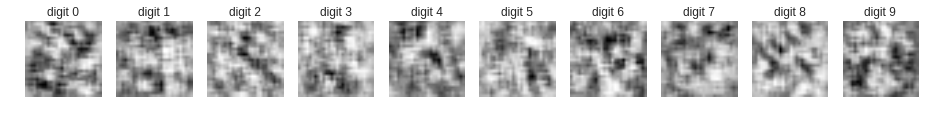

In [207]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(16,16))
for i in range(10):
    a=fig.add_subplot(1,10,i+1)
    lum_img = np.squeeze(w4w3w2w1[i])
    imgplot = plt.imshow(lum_img)
    a.set_title('digit {}'.format(i))
    plt.axis('off')
    plt.grid('off')

In [227]:
w3.shape


(3136, 512)